# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

# Initialization code

In [2]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/microservices_simgrid_reproductibility/comparison"

<a id='description'></a>
# 4th scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 2 computing node. The datasource will send requests to the first computing node.
Work amounts (loop iterations) is changing on the first compute node and is static on the second node. The scenario is launched several times with different amount of works. The first node once done processing the request sends it to the second node through rabbitmq, which will in turn send the result to the sink once finished as in scenario 1.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.

Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen4
Parallelization degree: 8
HostLogPath: /home/ccourageuxsudan/logs_expe/goLogs/reprod_scenario4_2021-04-09_09-12-03/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's parasilo cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/microbenchmarks/reprod_calib_2021-04-09_09-12-03/`
- For the execution: `results_reprod/microbenchmarks/reprod_scenario4_2021-04-09_09-12-03/`

## Synthetic Loads


We use 2 synthetic workloads to perform our experiments:

- Calibration workload: one request triggered every 3 seconds for 5 minutes (300 seconds)
- Execution workload: varying workload generated using LIMBO, with 3 spikes


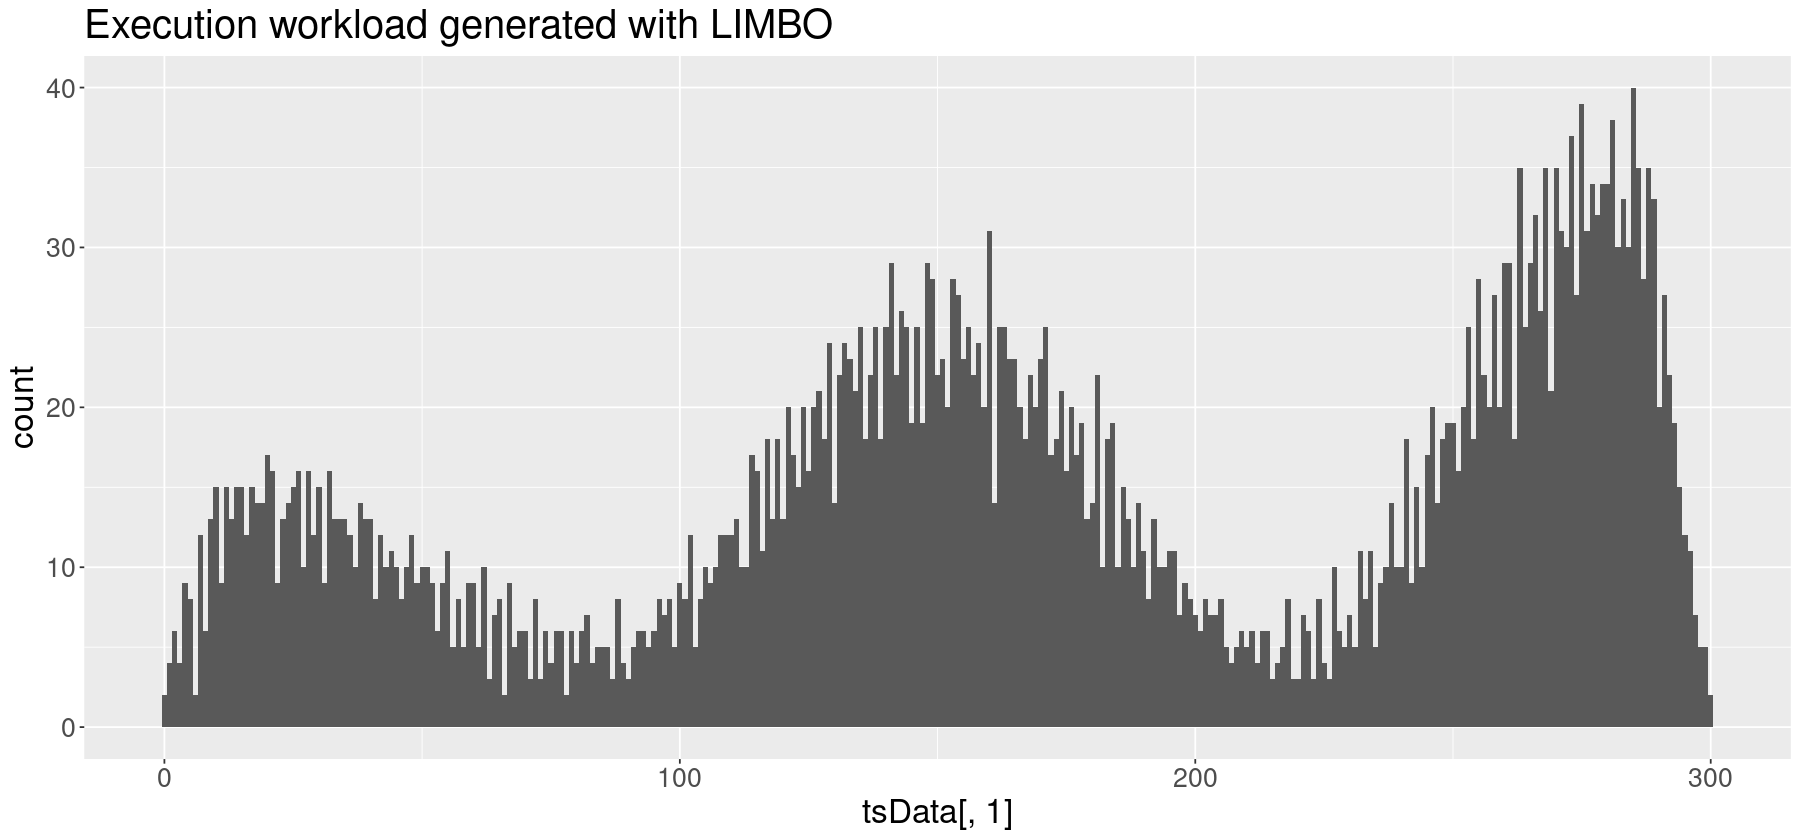

In [4]:
options(repr.plot.width=15, repr.plot.height=7)

tsData <- read.csv("./results_reprod/microbenchmarks/tsload.csv")

colnames(tsData) <- c("timestamp")

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Execution workload generated with LIMBO")

# Load Datasets

In [3]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("./results_reprod/microbenchmarks/reprod_calib_2021-04-09_09-12-03/4_aggrResults_1-10000000-100000002_4.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9
data_calibration$computeNode <- sub("\\_.*", "", data_calibration$serviceName)
summary(data_calibration)


data_calibration_sg <- as_tibble(read.csv("./results_reprod/microbenchmarks/sg_cal_scenario4.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("./results_reprod/microbenchmarks/sg_load_scenario4.csv"))

summary(data_SG_load)
data_load_RW <- as_tibble(read.csv("./results_reprod/microbenchmarks/reprod_scenario4_2021-04-09_09-12-03/4_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9
data_load_RW$computeNode <- sub("\\_.*", "", data_load_RW$serviceName)
summary(data_load_RW)


 serviceName            nbIter           timestamp          totDurInServ     
 Length:8800        Min.   :1.00e+00   Min.   :0.000e+00   Min.   :    1544  
 Class :character   1st Qu.:1.00e+06   1st Qu.:7.424e+10   1st Qu.:  386432  
 Mode  :character   Median :1.00e+06   Median :1.485e+11   Median :  494203  
                    Mean   :2.55e+07   Mean   :1.485e+11   Mean   : 8741128  
                    3rd Qu.:5.00e+07   3rd Qu.:2.228e+11   3rd Qu.:16754494  
                    Max.   :1.00e+08   Max.   :2.970e+11   Max.   :55082608  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     251   Min.   :0.0000   Min.   : 0.00   Length:8800       
 1st Qu.:  384207   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :  491848   Median :0.0000   Median :49.50   Mode  :character  
 Mean   : 8738747   Mean   :0.2618   Mean   :49.50                     
 3rd Qu.:16752182   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :55077705   Ma

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.02   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.02  
 Median :151.00   Median :151   Median :151   Median :151   Median :151.00  
 Mean   :151.01   Mean   :151   Mean   :151   Mean   :151   Mean   :151.01  
 3rd Qu.:226.00   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.00  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops              serv          
 Min.   :   80300   Length:2178       
 1st Qu.:  419800   Class :character  
 Median :  419800   Mode  :character  
 Mean   : 8737550                     
 3rd Qu.:17055300                     
 Max.   :34030300                     

       ts                qArr            instArr           startEx       
 Min.   :  0.4621   Min.   :  0.462   Min.   :  0.462   Min.   :  0.462  
 1st Qu.:118.2069   1st Qu.:118.199   1st Qu.:118.199   1st Qu.:118.199  
 Median :167.8179   Median :167.800   Median :167.800   Median :167.800  
 Mean   :172.7527   Mean   :172.740   Mean   :172.740   Mean   :172.740  
 3rd Qu.:259.6200   3rd Qu.:259.608   3rd Qu.:259.608   3rd Qu.:259.608  
 Max.   :299.9907   Max.   :299.990   Max.   :299.990   Max.   :299.990  
     endEx              flops              serv          
 Min.   :  0.4621   Min.   :   80300   Length:357026     
 1st Qu.:118.2069   1st Qu.:  419800   Class :character  
 Median :167.8179   Median :  419800   Mode  :character  
 Mean   :172.7527   Mean   : 7039998                     
 3rd Qu.:259.6200   3rd Qu.:13660300                     
 Max.   :299.9907   Max.   :27240300                     

 serviceName            nbIter           timestamp          totDurInServ      
 Length:1428440     Min.   :       1   Min.   :0.000e+00   Min.   :     1364  
 Class :character   1st Qu.: 1000000   1st Qu.:1.180e+11   1st Qu.:   424050  
 Mode  :character   Median : 1000000   Median :1.679e+11   Median :   661038  
                    Mean   :20500000   Mean   :1.728e+11   Mean   : 12673534  
                    3rd Qu.:40000001   3rd Qu.:2.600e+11   3rd Qu.: 14189124  
                    Max.   :80000001   Max.   :3.008e+11   Max.   :262179176  
   computeDur           parExec        totReqProcessed   scenario        
 Min.   :      235   Min.   :-1.0000   Min.   :   0    Length:1428440    
 1st Qu.:   422098   1st Qu.: 0.0000   1st Qu.:1088    Class :character  
 Median :   658515   Median : 0.0000   Median :2177    Mode  :character  
 Mean   : 12609782   Mean   : 0.6754   Mean   :2177                      
 3rd Qu.: 14187242   3rd Qu.: 1.0000   3rd Qu.:3265                      
 Ma

<a id='calibration'></a>
# Calibration Step

We perform it with one compute node only since they would execute on different cores and would both give very similar output.

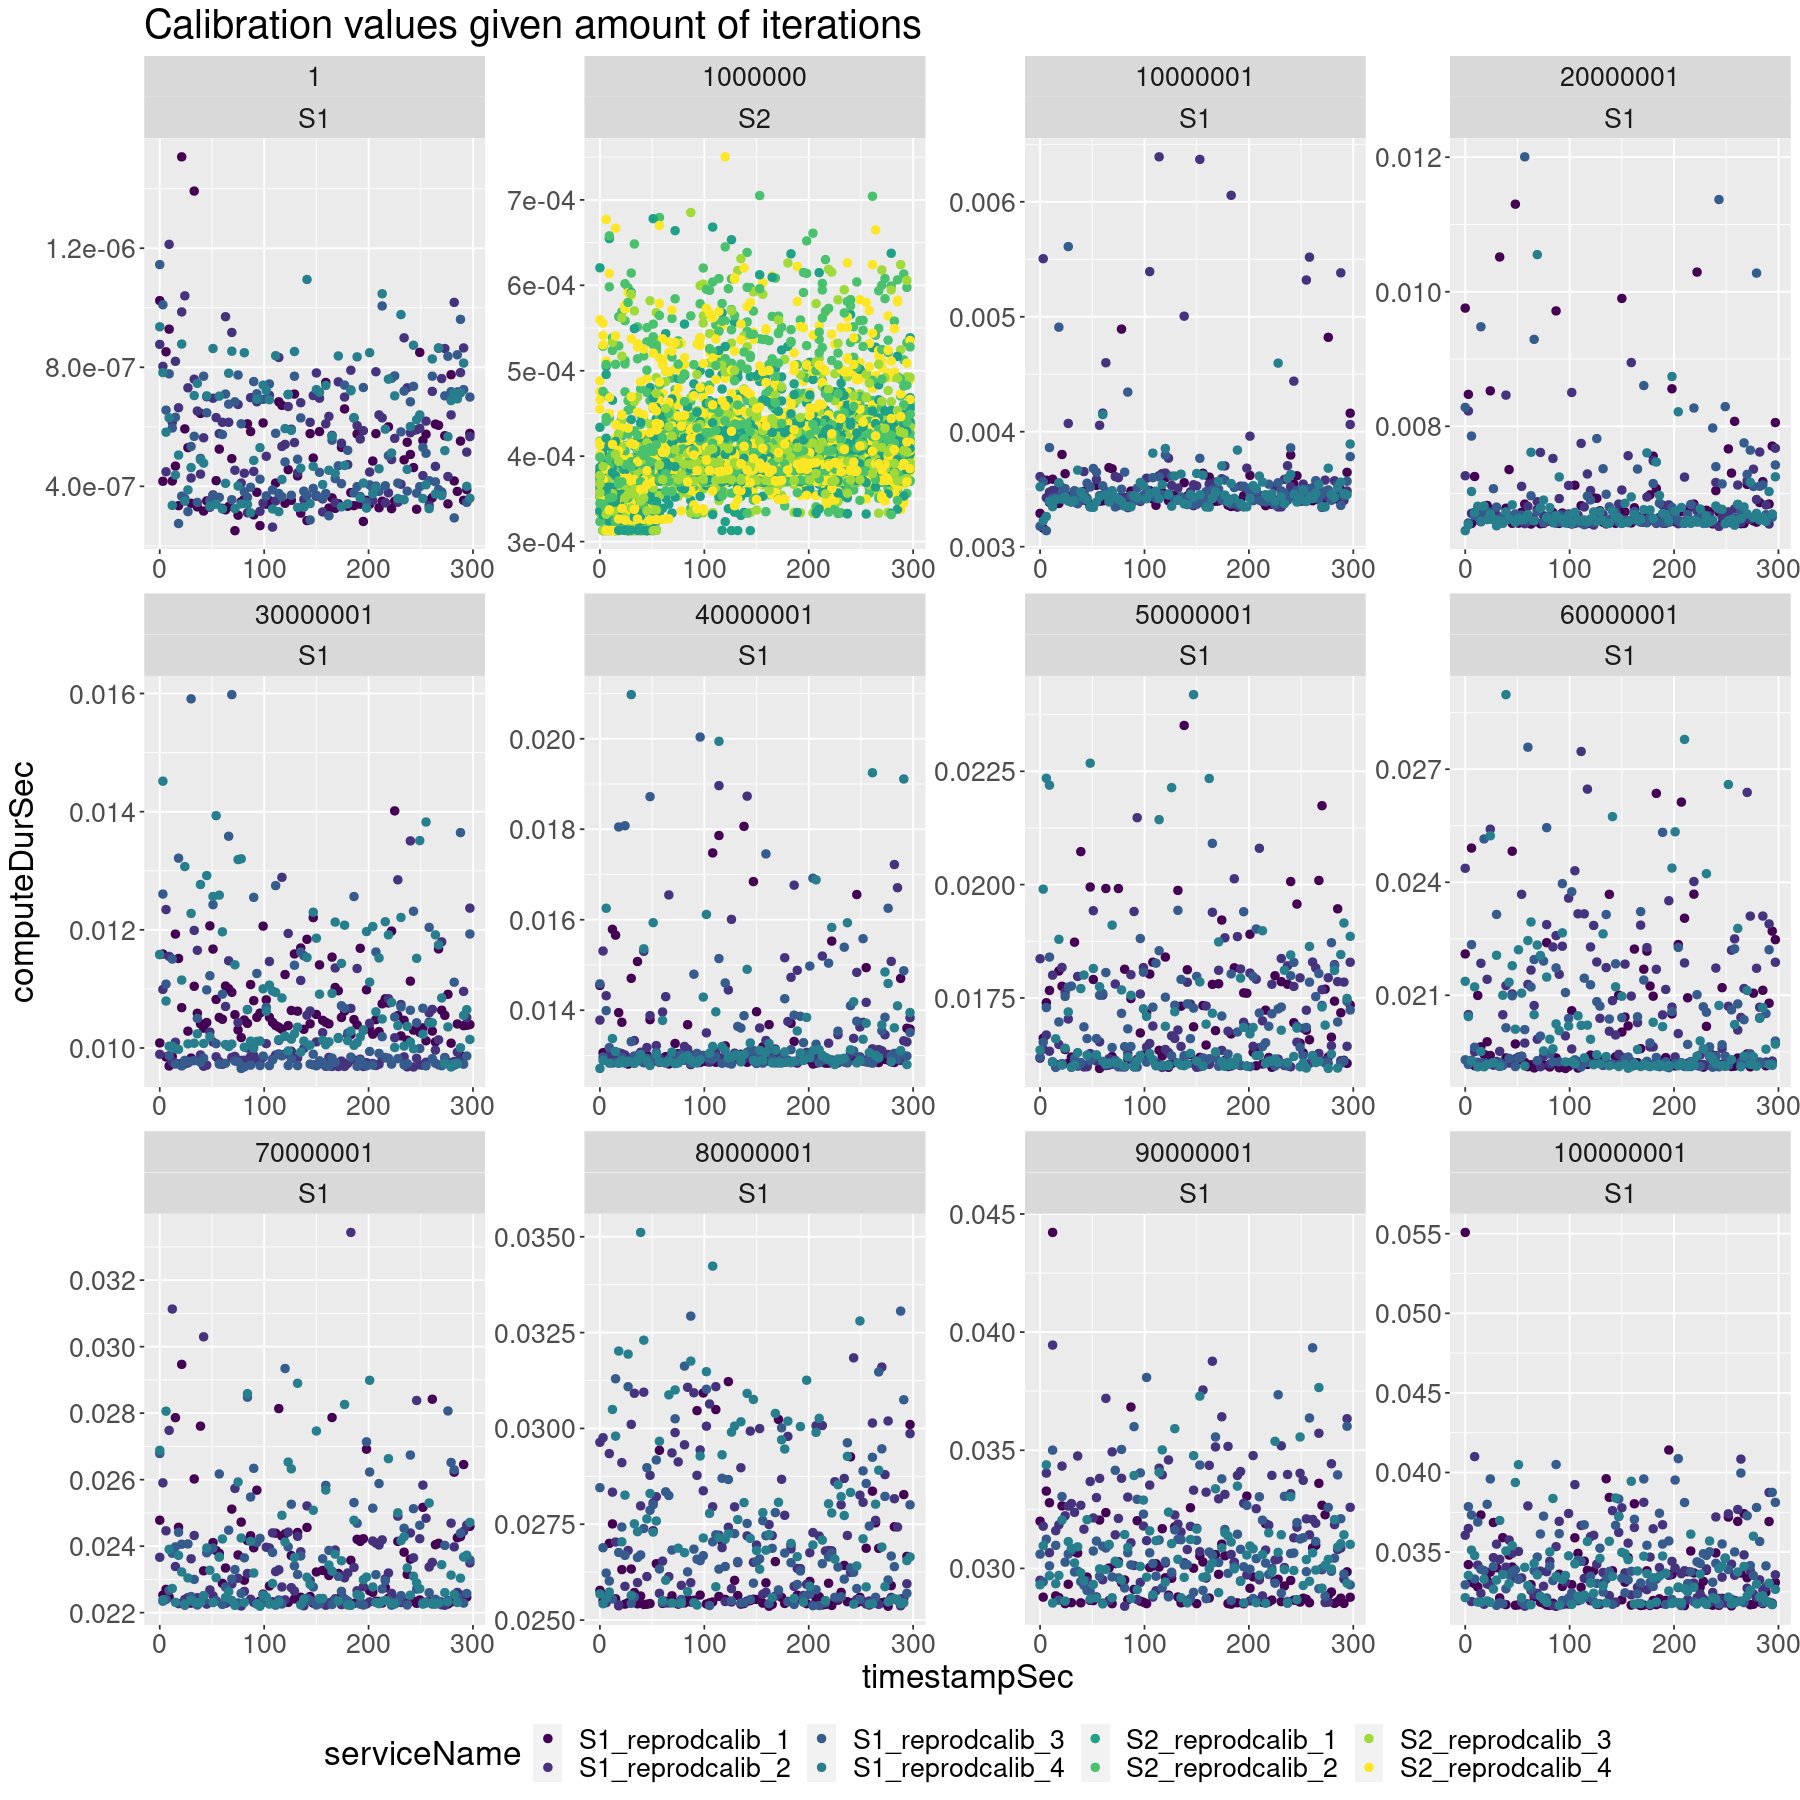

In [5]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap(nbIter ~ computeNode, scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

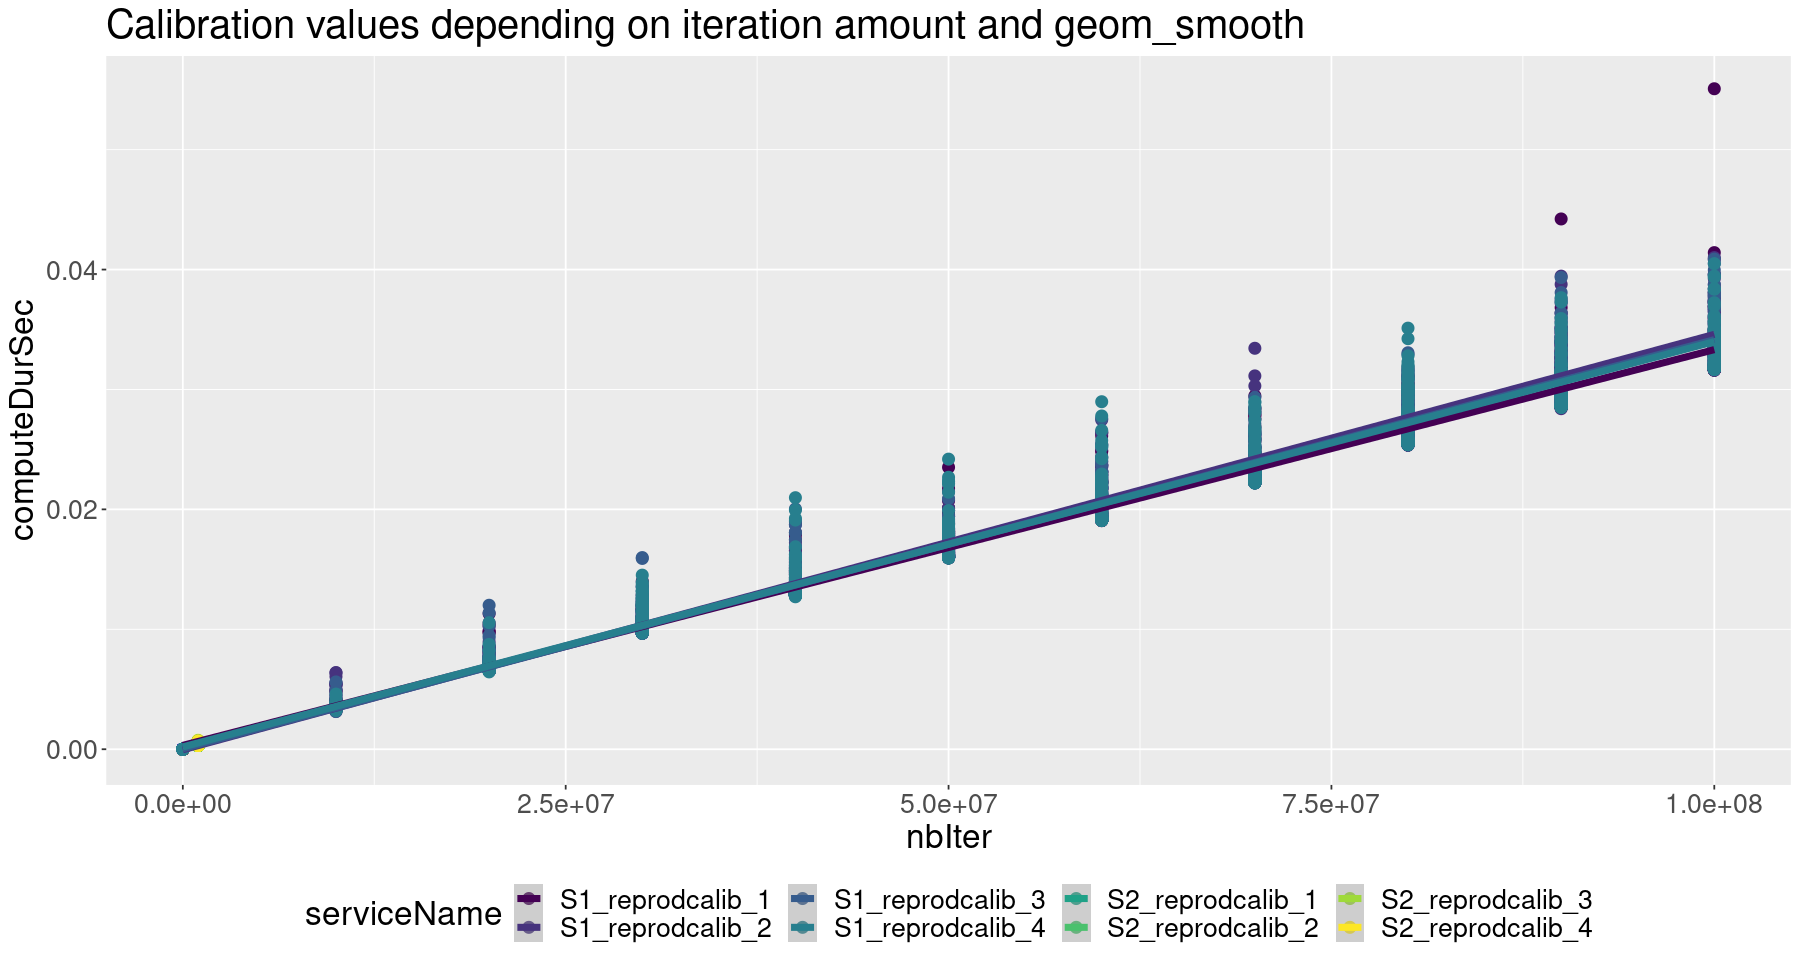

In [6]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [7]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0024363 -0.0001301 -0.0000404  0.0000204  0.0210427 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.030e-05  1.482e-05   5.417 6.21e-08 ***
nbIter      3.395e-10  3.543e-13 958.439  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001102 on 8798 degrees of freedom
Multiple R-squared:  0.9905,	Adjusted R-squared:  0.9905 
F-statistic: 9.186e+05 on 1 and 8798 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.395*10**(-10)+8.030*10**(-5)``` 

## Utility function to obtain duration from nbIter

In [8]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.395*10**(-10)+8.030*10**(-5))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.0849553
[1] 0.1698303
[1] 0.2547053


## Calibration comparison between real world data and SimGrid

In [9]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

80300  3475300  6870300  10265300  13660300  17055300  20450300  23845300  27240300  30635300  34030300  

In [10]:
# compute fixed cost of 1000000 loops for compute node 1

start=1000000
end=1000000
iter=1

nbIter_to_duration_to_SG(start, end, iter)

419800  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_cal_scenario4.csv
for i in 80300  3475300  6870300  10265300  13660300  17055300  20450300  23845300  27240300  30635300  34030300  
do
    echo "Calibration for iterAmount=$i"
    scenario=4 fixedCost=419800 parDeg=8 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_cal_scenario4.csv
done
```

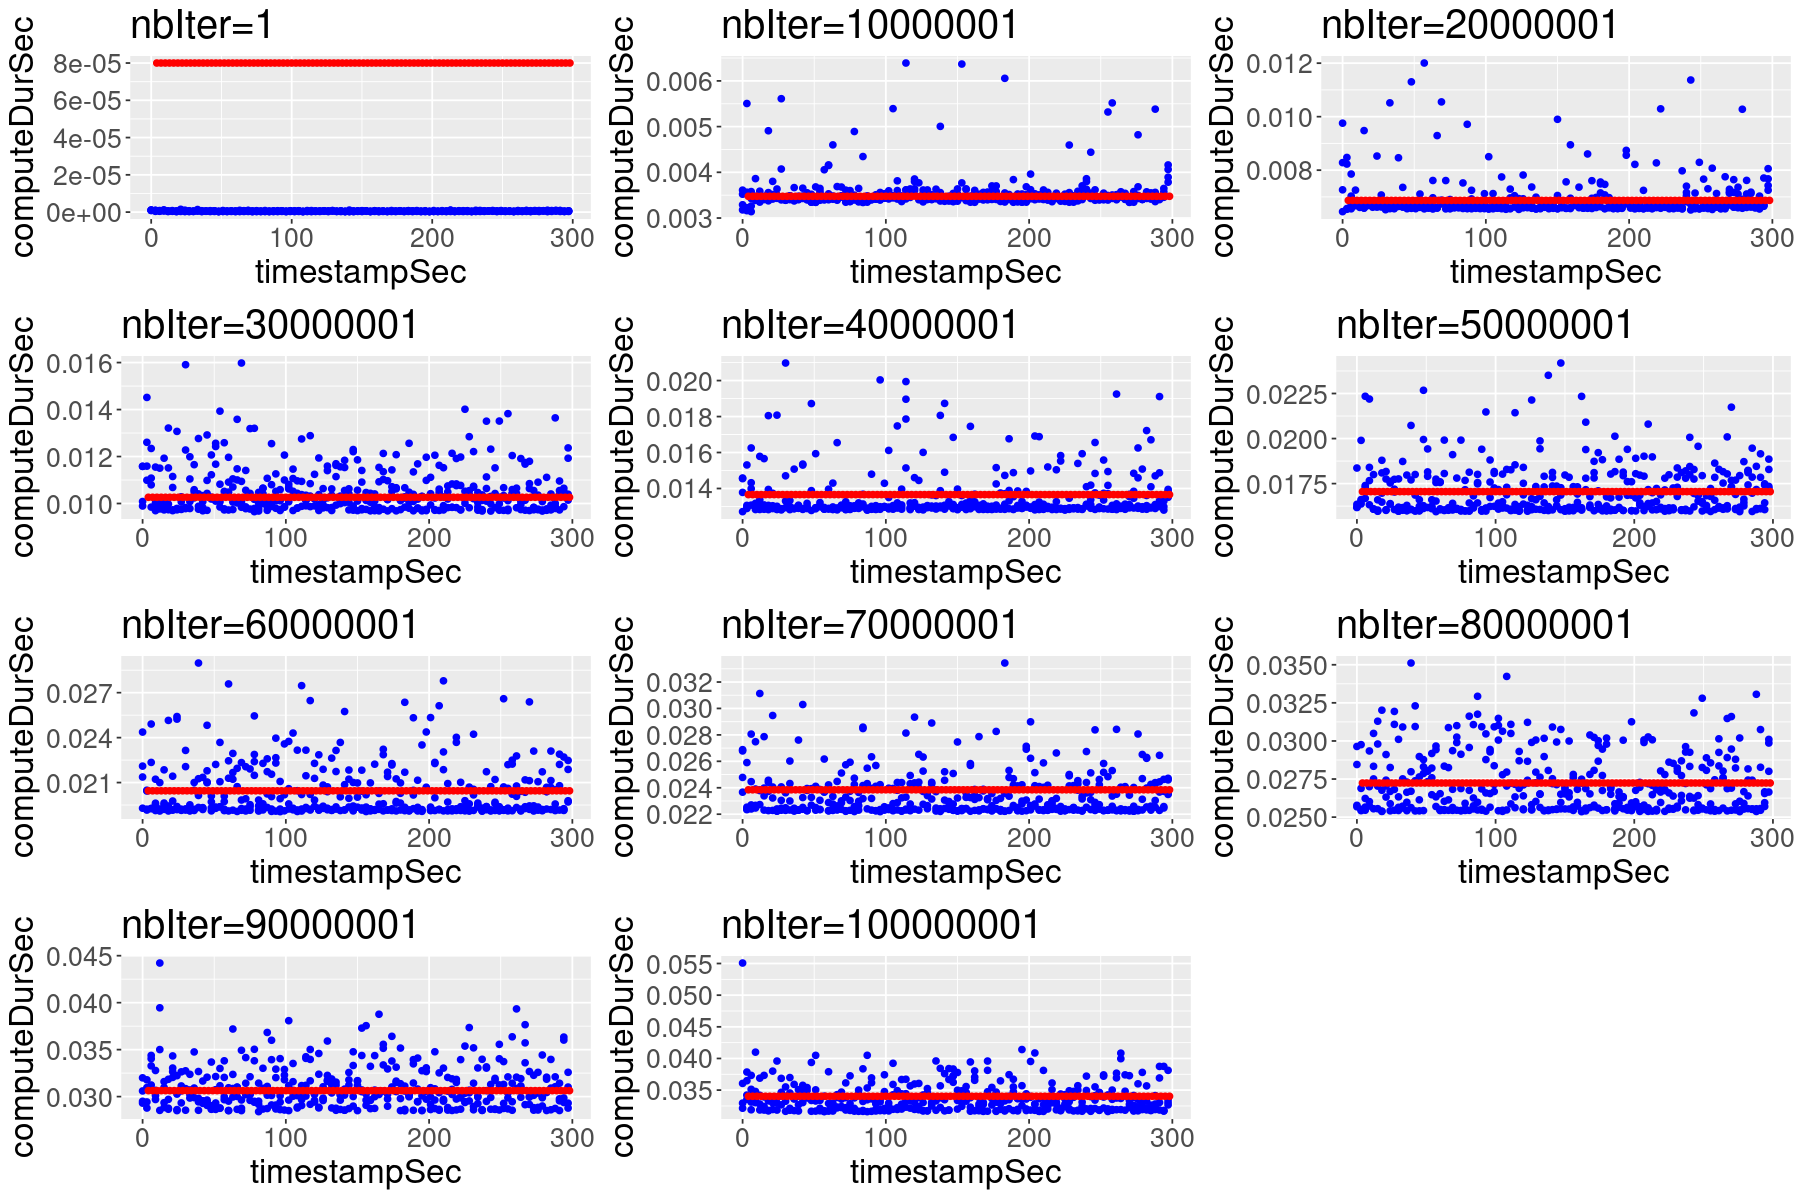

In [11]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

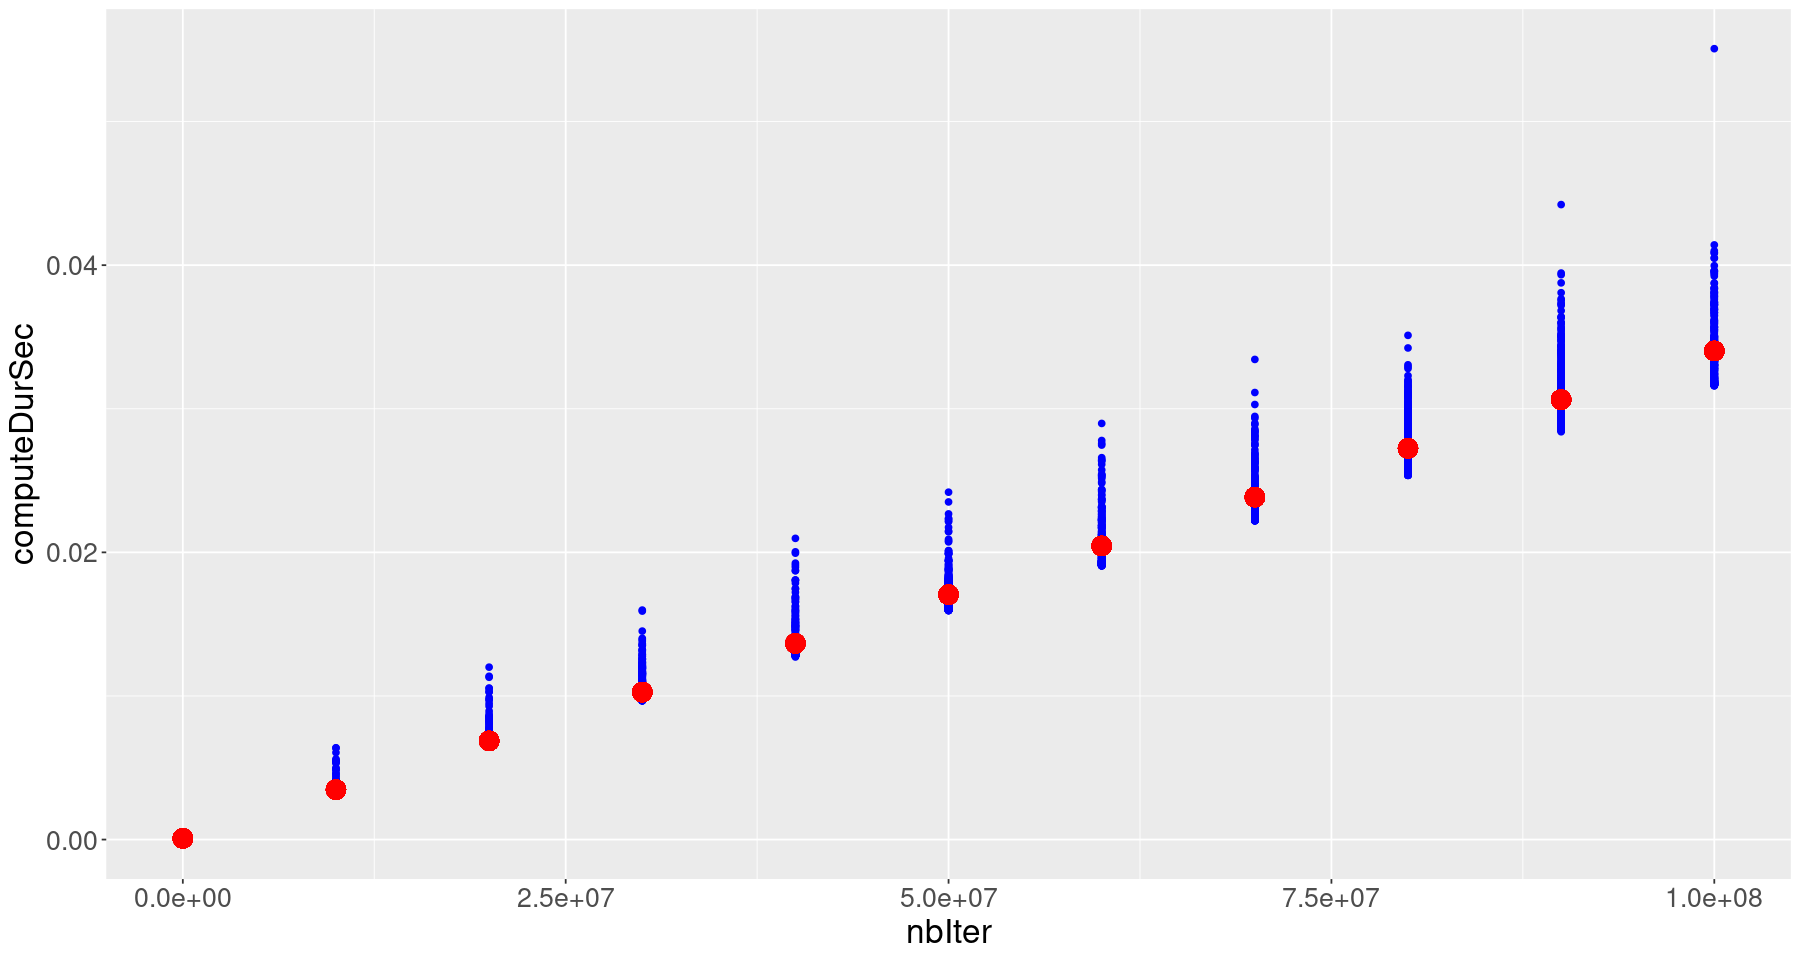

In [12]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [13]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

# fixed cost didn't change since calibration

80300  759300  1438300  2117300  2796300  3475300  4154300  4833300  5512300  6191300  6870300  7549300  8228300  8907300  9586300  10265300  10944300  11623300  12302300  12981300  13660300  14339300  15018300  15697300  16376300  17055300  17734300  18413300  19092300  19771300  20450300  21129300  21808300  22487300  23166300  23845300  24524300  25203300  25882300  26561300  27240300  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario4.csv
for i in 80300  759300  1438300  2117300  2796300  3475300  4154300  4833300  5512300  6191300  6870300  7549300  8228300  8907300  9586300  10265300  10944300  11623300  12302300  12981300  13660300  14339300  15018300  15697300  16376300  17055300  17734300  18413300  19092300  19771300  20450300  21129300  21808300  22487300  23166300  23845300  24524300  25203300  25882300  26561300  27240300
do
    echo "Calibration for iterAmount=$i"
    scenario=4 parDeg=8 fixedCost=419800 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario4.csv
done
```

# Time spent in first node

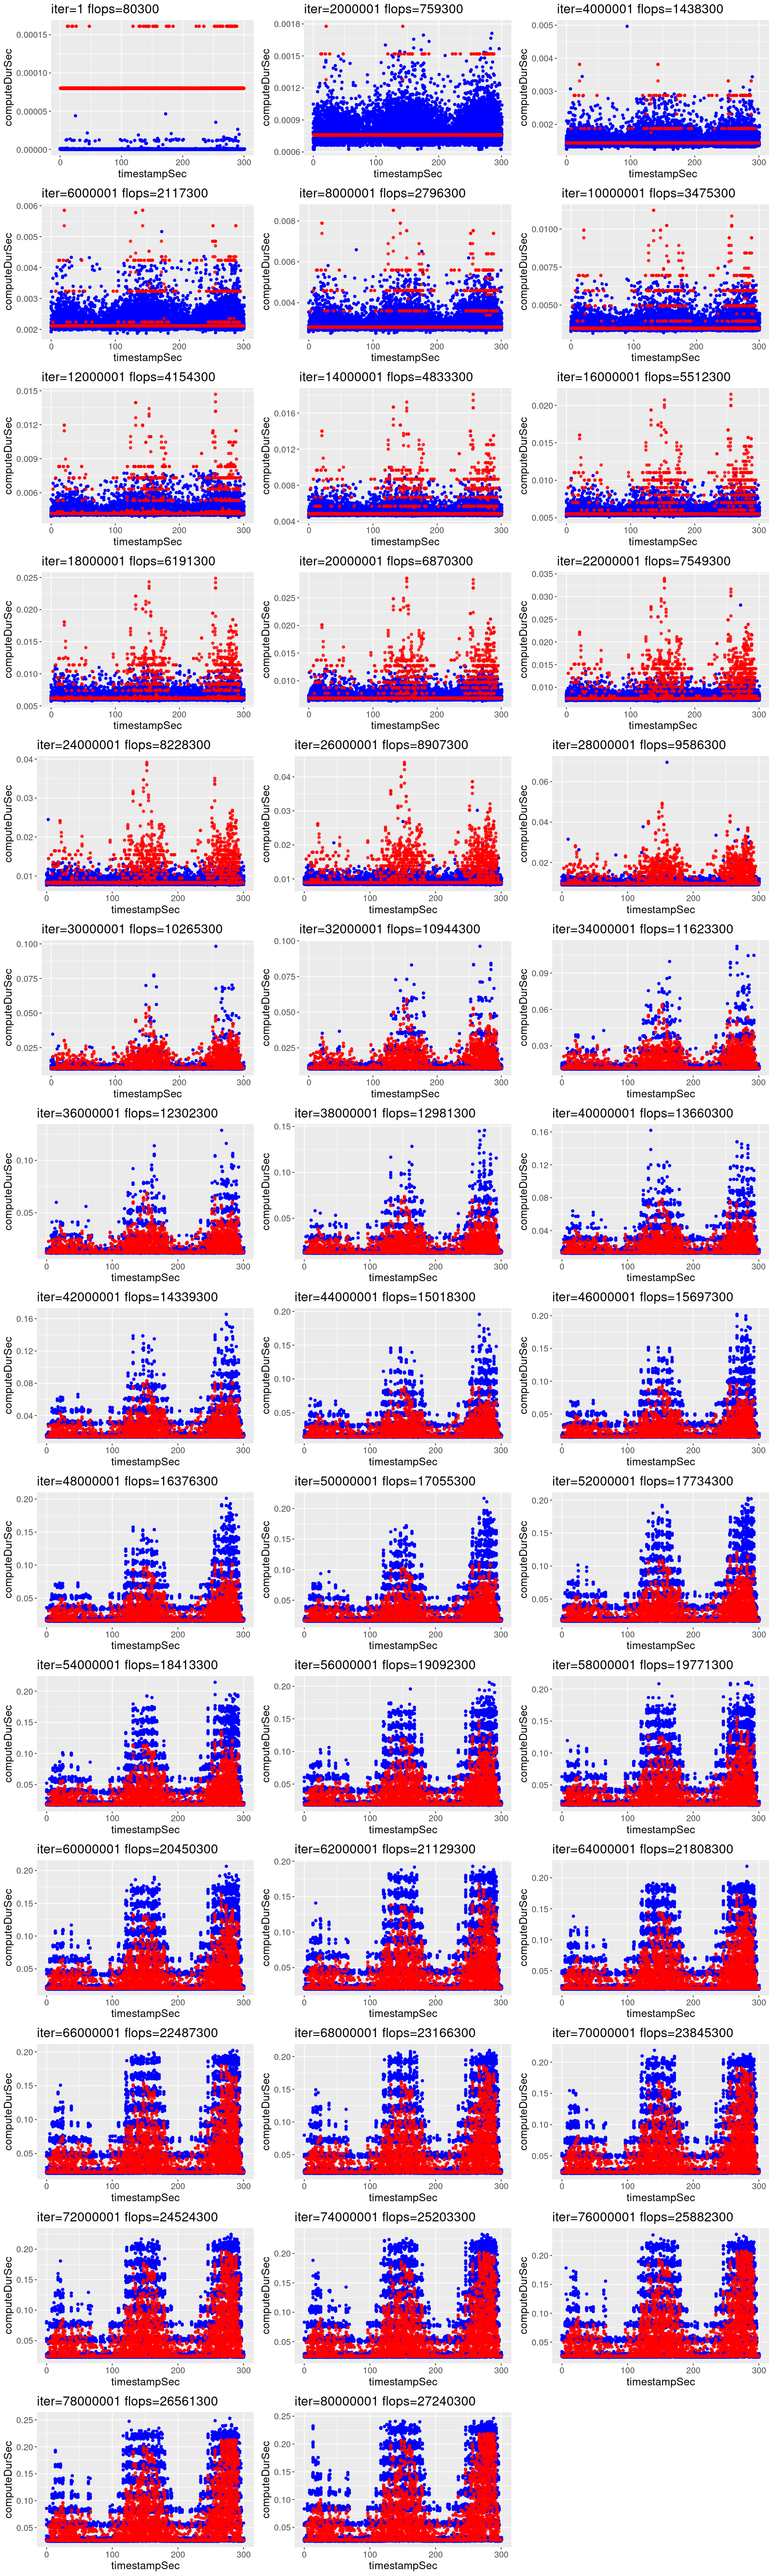

In [14]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service1" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S1" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))


# Time spent in second node

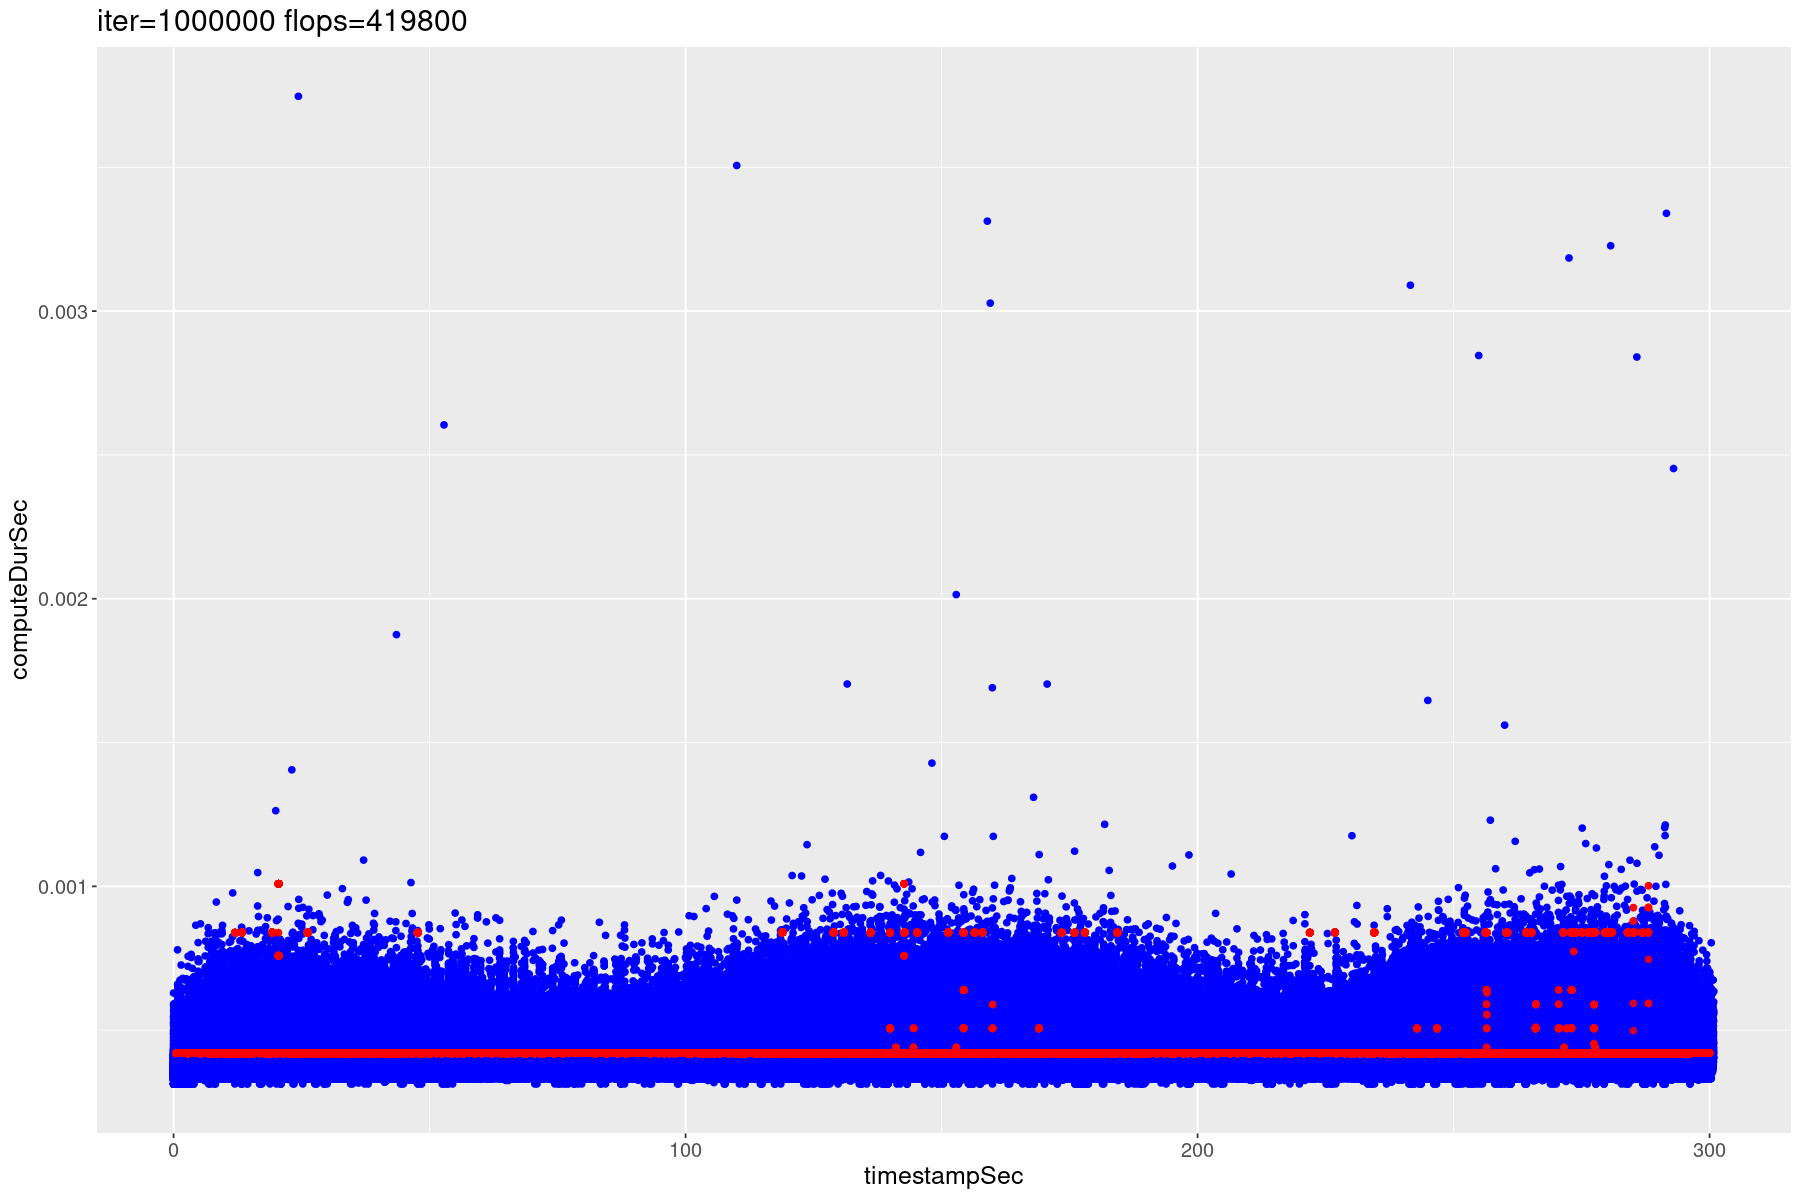

In [15]:

options(repr.plot.width=15, repr.plot.height=10)

P <- list()
for(i in seq(from=1000000, to=1000000, by=1)){
    tmpsg <- subset(data_SG_load, serv=="service2" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S2" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P))
